## Project 2 : Feature matching and the SVD

## Question 1(a) 

1.Find SIFT features in image A


2.Find SIFT features in image B



3.Use descriptors to match features across the two images.



Some terminology to clear before coding


keypoints(features) :  keypoint(x,y,$\sigma$) , keypoint has information about coordinates, orientation and scale.





descriptors: a patch around the feature.the numpy array shape, the dimension is n*128 matrix  ,where n is the number of keypoints




kp1 : the number of keypoints in image1 , the descriptor_1 is a kp1*128 matrix 




kp2 : the number of keypoints in  image2,  the descripotr_2 is a kp2*128 matrix




Once we detect the keypoints and have the descriptors.




Next, match the descriptors.  the result is kp1[m] corresponds to kp2[matches[m]] = kp2[n].



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
from operator import itemgetter
import math
from scipy.misc import imresize

path="/home/li/Desktop/_computation/computer_vision/project2_material"
os.chdir(path)
img1 = cv2.imread('semper1.jpg',0) # query image
img2 = cv2.imread('semper2.jpg',0) # train image

def sift_feature_match(img1,img2):
    """This function using sift to detect features and draw these featues
     input two images, the sift matches two corresponding features."""
    
       # Initiate ORB detector
    orb = cv2.ORB_create() 
    kp1, des1 = orb.detectAndCompute(img1,None)  # find the keypoints and descriptors with ORB
    kp2, des2 = orb.detectAndCompute(img2,None)
    
    img_kp1=cv2.drawKeypoints(img1,kp1,img1,(255,0,0),flags=0)
    img_kp2=cv2.drawKeypoints(img2,kp2,img2,(255,0,0),flags=0)
    
    #bf = cv2.BFMatcher() # BFMatcher with default params
    #matches = bf.knnMatch(des1,des2, k=2)
    bf=cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
    matches=bf.match(des1,des2)
    matches=sorted(matches,key=lambda x:x.distance)  #the distance in decreasing order
      
    img_mat = cv2.drawMatches(img1,kp1,img2,kp2,matches[:30],(255,0,0),(255,0,0),flags=2) # show   matches[:30]
    #return img_f1,img_f2,img_mat
    dist = []
    coord1=[]   #the coordinates of keypoints1
    coord2=[]   #the coordinates of keypoints2
    for i in matches[:100]:
        
        kp11=i.queryIdx  #get the matched query index
        kp22=i.trainIdx   # get the matched train index
        
        #(x1,y1)=int(kp1[kp11].pt[0]) 
        #(x2,y2)=int(kp2[kp22].pt) 
        
        x1,y1 = int(kp1[kp11].pt[0]),int(kp1[kp11].pt[1]) #get keypoints coordinates from  kp1, convert to integers
        x2,y2 = int(kp2[kp22].pt[0]),int(kp2[kp22].pt[1]) #get keypoints  coordinates from  kp2,convert to integers
    
        coord1.append((x1,y1))
        coord2.append((x2,y2))
           
    return img_kp1,img_kp2,img_mat,coord1,coord2
    #print(len(kp1),len(kp2),len(matches),dist)  
    #print(coord1)   
    #print(coord2)
    #print(kp1,kp2)
detect = sift_feature_match(img1,img2)

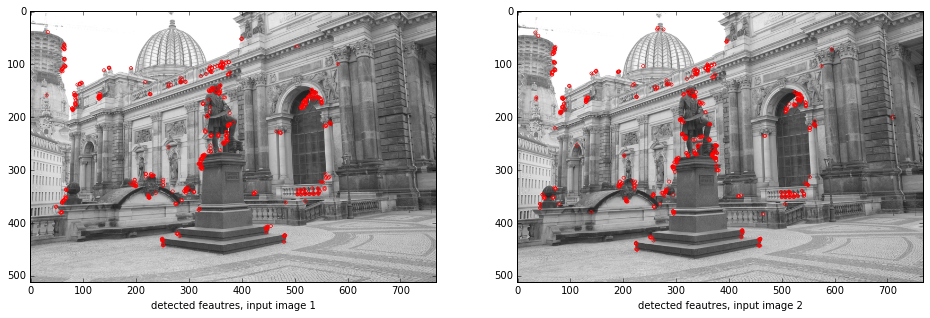

In [2]:
plt.figure(figsize=(16,8))
for i in range(0,2):
    plt.subplot(1,2,i+1)
    plt.imshow(detect[i])
    plt.xlabel("detected feautres, input image %d"%(i+1))

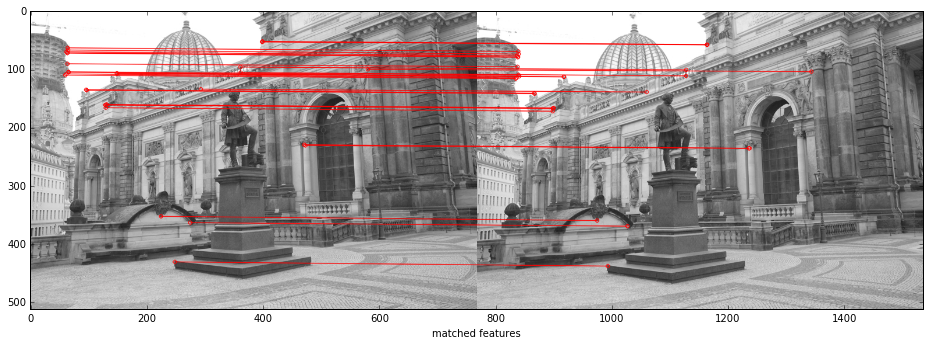

In [3]:
plt.figure(figsize=(16,8))
plt.imshow(detect[2])
plt.xlabel("matched features")

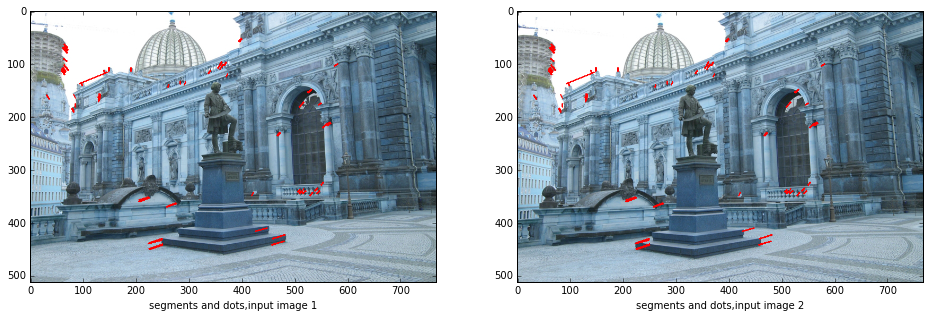

In [4]:
def dots_segments(query,train):
    img1coord = detect[3]
    img2coord = detect[4]
    for i,j in zip(img1coord,img2coord):
        seg1= cv2.line(query,i,j,(255,0,0),2,8)  #draw dots and segments on query image
        seg2= cv2.line(train,i,j,(255,0,0),2,8)     #draw dots and segments on train image
    return seg1,seg2

path="/home/li/Desktop/_computation/computer_vision/project2_material"
os.chdir(path)
img1 = cv2.imread('semper1.jpg') # query image
img2 = cv2.imread('semper2.jpg') # train image

movement = dots_segments(img1,img2) #call function

plt.figure(figsize=(16,8))
for i in range(0,2):
    plt.subplot(1,2,i+1)
    plt.imshow(movement[i])
    plt.xlabel("segments and dots,input image %d"%(i+1))

## Question 2     

I have managed to get the coordinates of  keypoints both in image A and in image B, and multiply the scale factor to coordinates in A and then caculate the distance to B coordinates, but I get stuck because if I multiply scale=1 to A coordinates , the distance to B is supposed to be 0, while the code resulted with non zeros.

In [5]:
from scipy.misc import imresize

def resize():
    
    path="/home/li/Desktop/_computation/computer_vision/project2_material"
    os.chdir(path)

    A = cv2.imread('semper1.jpg',0) # input image A
    resize_A = [imresize(A,i,interp="bilinear") for i in np.arange(0.2,5.1,0.1)] #rescaled image A, a list
    
    Akp=[]
    Bkp=[]
    A_coord=[]
    B_coord=[]
    Anew_coord=[]
    dist=[]
    for B in resize_A:  #then B is individual resized image
        
        rescale = sift_feature_match(A,B)  #call the sift_feature_match funtion,and match the pair(A,B)
        
        kpA=rescale[0]
        kpB=rescale[1]
        Axy = rescale[3]
        Bxy = rescale[4]
        Akp.append(kpA)
        Bkp.append(kpB)
        
        A_coord.append(Axy)
        B_coord.append(Bxy)
        
        for j in np.arange(0.2,5.1,0.1):
            Axy_new = [tuple([int(m*j) for m in i]) for i in Axy] #rescale the A coordinate to corresponding B level
           
            d =[np.sqrt((m[0]-n[0])**2+(m[1]-n[1])**2) for m,n in zip(Axy_new,Bxy)] #Caculate the NewA and B coordinate distance 
            
            Anew_coord.append(Axy_new)
            dist.append(d)
            
    #return A_coordnew,B_coord
    #print(len(A_coord[8]))
    #print(B_coord[8])
    #print(dist[8])
resize()

100
[348.17380717107369, 300.52786892399848, 535.29150936662541, 121.19818480488888, 330.037876614185, 435.62024746331525, 293.58644382872995, 545.88643507601466, 342.47627655065395, 307.53861546153843, 438.61714512772983, 128.65846260545786, 351.19367875860178, 131.59027319676784, 101.86756107809786, 432.13423840283701, 459.5835071018106, 509.21900985725188, 122.80065146407001, 358.91224554199874, 461.57664585635177, 288.44410203711914, 166.23477373883, 291.35888522576414, 533.80239789645009, 357.89663312191135, 70.774289116881988, 466.50723467058901, 333.29416436535456, 548.9927139771529, 301.39177161959816, 534.10485861860502, 129.12009913255179, 298.16773802676909, 316.10124960208555, 296.23301639081353, 520.31240615614774, 545.66839747231097, 306.18458485038076, 309.01456276363416, 532.78982723021284, 523.45009313209607, 538.06783958902429, 131.04197800704932, 346.10114128676315, 339.33022264455019, 23.194827009486403, 399.69988741554579, 322.12575184235118, 295.16097302997224, 31

Question  3(a) 



## $A=U\sum V^T$ , singular values are aranged in decending order, thus the first singular contains the greatest amount of image information , while other values carries the decreasing image information.

In [179]:
cd /home/li/Desktop/_computation/computer_vision

/home/li/Desktop/_computation/computer_vision


The shape of input image: (800, 480)
The shape of matrix U: (800, 800)
The shape of s(sigular value): (480,)
The shape of matrix V: (480, 480)
The rank of the matrix A is: 480


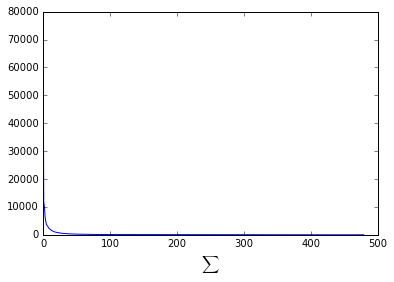

In [49]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import linalg
A= np.array(Image.open('exp2.png').convert("L")) 
U,s,VT=linalg.svd(A)
print("The shape of input image:",A.shape)
#S=np.diag(s)
rank=np.linalg.matrix_rank(A)
print("The shape of matrix U:",U.shape)
print("The shape of s(sigular value):",s.shape)
print("The shape of matrix V:",VT.shape)
print("The rank of the matrix A is:",rank)

plt.plot(s)
plt.xlabel(r"$\sum$",fontsize=12)

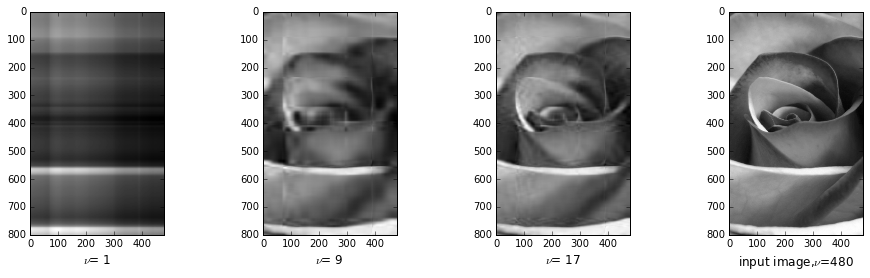

In [50]:
plt.figure(figsize=(16,4))
for i,ν in enumerate(range(1,27,8)): # number of reduced
    U_r=U[:,:ν]
    s1=np.diag(s)
    s_r=s1[:ν,:ν]
    VT_r=VT[:ν,:]
    A_v=np.dot(np.dot(U_r,s_r),VT_r)
    plt.subplot(1,4,i+1)
    plt.imshow(A_v,cmap=plt.cm.gray)
    plt.xlabel(r"$\nu$= %d "% ν,fontsize=12)
plt.imshow(A,cmap=plt.cm.gray)
plt.xlabel(r"input image,$\nu$=480",fontsize=12)

Clearly, the smaller $\nu$ , the "blockier" the image.

### (b) Since $\nu \times \nu$ represents the dimension of the matrix $\sum_\nu$, small $\nu$ means small rank of matrix A. when we use this truncated U_$\nu$ matrix , singular value matrix $\sum_\nu$ and V_$\nu$ matrix to reconstruct $A_\nu$ .$$A_\nu = U_\nu \sum _\nu V_{\nu}^T$$  Though the dimension of  $A_\nu$ doesn't change, the value of  $A_\nu$ matrix will be changed, the smaller $\nu$, the more values of  $A_\nu$ will be set to 0, thus the  image details are lost.  Therefore, the intensity values of the reconstructed image will be blokcky.

The effective compression ratio is 37


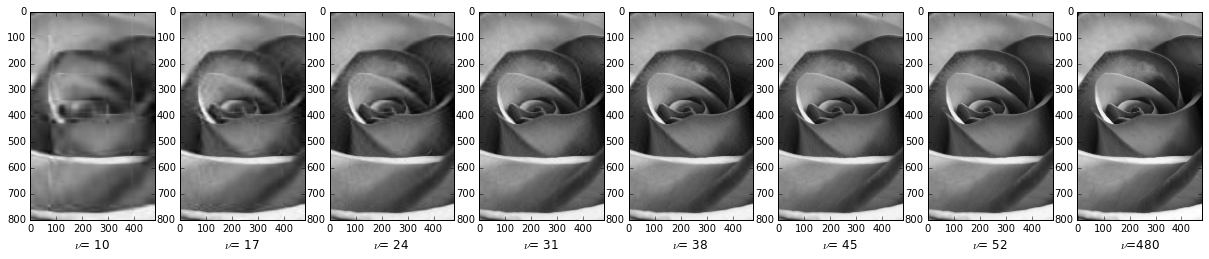

In [182]:
m,n=A.shape
ν = m*n/(8*(m+n+1))
print("The effective compression ratio is %d"%ν)
plt.figure(figsize=(21,8))
for i,ν in enumerate(range(10,60,7)): # number of reduced
    U_r=U[:,:ν]
    s1=np.diag(s)
    s_r=s1[:ν,:ν]
    VT_r=VT[:ν,:]
    A_v=np.dot(np.dot(U_r,s_r),VT_r)
    plt.subplot(1,8,i+1)
    plt.imshow(A_v,cmap=plt.cm.gray)
    plt.xlabel(r"$\nu$= %d "% ν,fontsize=12)

plt.imshow(A,cmap=plt.cm.gray)
plt.xlabel(r"$\nu$=480",fontsize=12)

### 3(c) To achieve image compression, $\nu$ is required to be smaller than $\frac{m \times n}{8(m+n+1)}$. In fact, the degree of the image compression competes against the image quality, in other words, higher compression comes with poorer image quality.

### 3(d) If the singular values of an image do not decrease rapidly, then it is difficult for us to do image compression, since large amount of the singular values carry useful image information, we can not simply set them to be zero. 

## Question 4


## Face recognition algorithm
1.Read n images, the shape of each input image is $p\times q$, then tranform them into dimension $m\times 1$ $f_i$,vectors, where (i=1,2...n)  ,  $m = p\times q$ .


2.Compute the average n vectors ,   $  \mu = \underline{a} = \frac{1}{n}\sum_{i=1}^{n}f_i$ .

3.Compute the SVD of matrix $ A $, $ A_i = f_i - \underline{a} $ . Normally, it is difficult to solve, we solve  $L = A^T A$, the dimensiton is ($n\times n$). compute the eigenvector V of L, then the eigenface is $U = V*A$, apparently, it has to be normalised.

4.$ y = U_{\alpha}^T(f-\underline{a}) .  $The $\alpha \times 1 $vector y in this expression is called the eigenface representation for each $f_i$. $$f_i - \underline{a} = \sum _{j=1}^{\alpha} U_\alpha  y_\alpha $$.

5.projecting all training faces into the above equation getting $y_1$, then projecting the test face obtaining $y_2$ . The distance between two eigenface representations $y_1 \mbox{and } y_2$ can be measured as norm $\| y_1 - y_2 \|$, and it is to be compared with an user defined threshold value.


In [46]:
cd ..

/home/li/Desktop/_computation/computer_vision


In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import linalg
import os
from scipy import linalg
from sklearn.preprocessing import normalize

print(os.getcwd())
path="/home/li/Desktop/_computation/computer_vision/faces_training"
os.chdir(path)
files=os.listdir(path)
im = np.array(Image.open(files[0])) 
p,q=im.shape
print("the shape of each input image:",(p,q))

f = np.array( [np.array(Image.open(i)).flatten() for i in files],"f") #n*m matrix , m=p*q
print("the shape of vector f:",f.shape)

def face_train(X):
    n,m= X.shape # get dimensions of X n*m
    mean_X = np.mean(X,axis=0)  #column average ,1/n
    A = (X-mean_X)/np.sqrt(n)
    X = A.T
    #if m>n:
        #M = np.dot(A.T, A)  #the dimension of M is n*n
        # u,s,v_t = np.linalg.svd(M) 
        #v=v_t.T
        #U_unnorm= np.dot(A,v) #caculating eigenfaces ,the dimension is m*alpha
        #U=normalize(U_unnorm,norm="l1",axis=1)  #row normalize U ,1/alpha
        #y=np.dot(U.T,A)  #eigenface representation for all the input image, the dimension is alpha*n
    #else:
    u,s,v=np.linalg.svd(X)
    U=u
    y=np.dot(U.T,X)  #the dimension is alpha*n
        
    return mean_X,U,y

/home/li/Desktop/_computation/computer_vision
the shape of each input image: (112, 92)
the shape of vector f: (40, 10304)


(-0.5, 91.5, 111.5, -0.5)

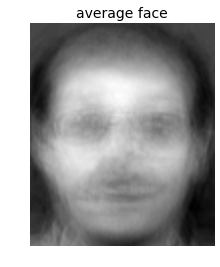

In [2]:
train=face_train(f) #call face_train function

a_train = train[0]
U_train = train[1]
y_train = train[2]

average = a_train.reshape(p,q)
plt.imshow(average,cmap=plt.cm.gray)
plt.title("average face",fontsize=14)
plt.axis("off")

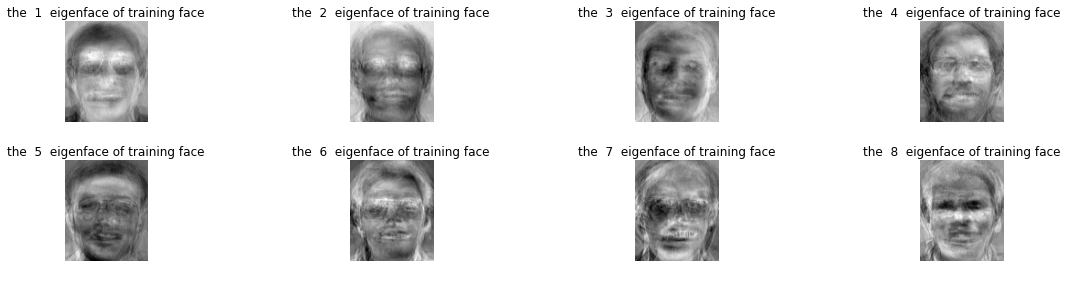

In [3]:
plt.figure(figsize=(16,4))
for i in range(1,9):
    plt.subplot(2,4,i)
    plt.imshow(U_train[:,i].reshape(p,q),cmap=plt.cm.gray)
    plt.title("the  %d  eigenface of training face"%i)  
    plt.axis("off")
plt.tight_layout()

## Question 4(b)   

Caculating the query image $f^{'}$  eigenface representions, $$ y'=U^T(f'-a)$$, where $ U^T$ and $a$  come from training set.

In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import linalg
import os
from scipy.spatial import distance
from operator import itemgetter

def face_iden(file_new,file_train,y_train,a_train,U_train):
    f_new = np.array( [np.array(Image.open(i)).flatten() for i in file_new],'f')  #the dimension is n*m
    n = len(file_new)
    A_new = (f_new-a_train)/np.sqrt(n) 
    X_new = A_new.T  #the dimension is m*n
    y_new = np.dot(U_train.T,X_new) #the eigenface representation of test1 image  y'=U^T(f'-a).  r*n
    
    test_recog=np.arange(y_new.shape[1])
    lis_train = []
    dist = []
    for i in test_recog: #for each image in test set, find the least distance in training set.

        d = [distance.euclidean(y_new[:,i],y_train[:,j]) for j in range(y_train.shape[1])] 
        #d = [plt.mlab.dist(y_new[:,i],y_train[:,j]) for j in range(y_train.shape[1])]
        match = min(enumerate(d),key=itemgetter(1))[0]  #get the index of least || y_1 and y_train|| in training
        lis_train.append(match)  
    compare=zip(lis_train,test_recog)
    plt.figure(figsize=(20,20))
    for i,j in compare:
        os.chdir(path)
        im = np.array(Image.open(file_train[i]))
        os.chdir(path1)
        im1 = np.array(Image.open(file_new[j]))
        combine = np.concatenate((im,im1),axis=1)
        plt.subplot(10,4,j+1)
        plt.imshow(combine,cmap=plt.cm.gray)
        plt.axis("off")
    plt.title("the left is training set, the right is test1 set")

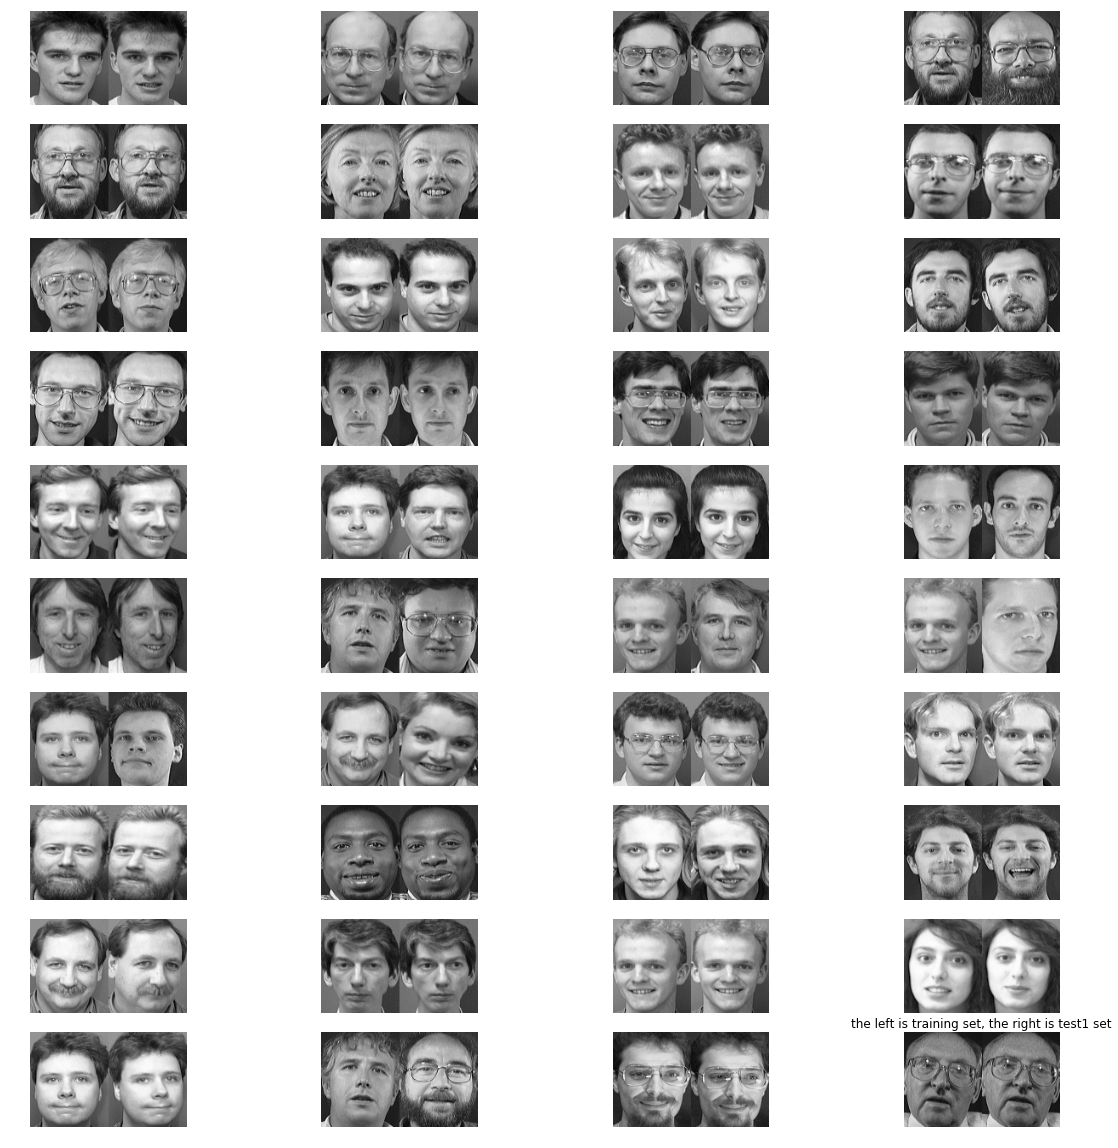

In [73]:
path="/home/li/Desktop/_computation/computer_vision/faces_training"
os.chdir(path)
file_train=os.listdir(path)
path1="/home/li/Desktop/_computation/computer_vision/faces_test/test1"
os.chdir(path1)
files1=os.listdir(path1)
face_iden(files1,file_train,y_train,a_train,U_train)  #call the face_iden function

In [74]:
print("The correctness comparing test1 and training set is: %.2f"%(32/40))

The correctness comparing test1 and training set is: 0.80


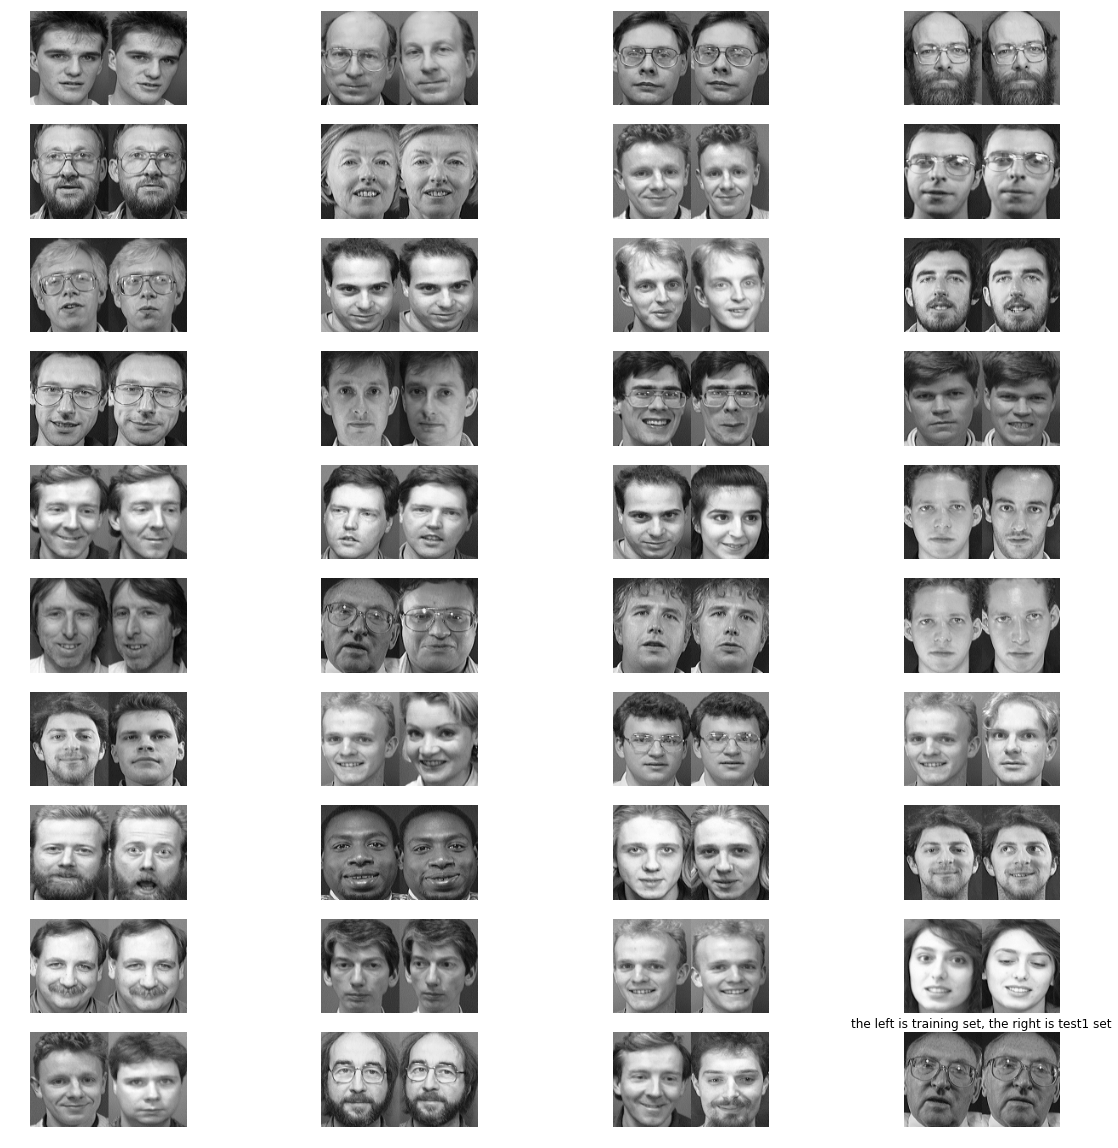

In [69]:
path="/home/li/Desktop/_computation/computer_vision/faces_training"
os.chdir(path)
file_train=os.listdir(path)
path1="/home/li/Desktop/_computation/computer_vision/faces_test/test2"
os.chdir(path1)
files1=os.listdir(path1)
face_iden(files1,file_train,y_train,a_train,U_train)  #call the face_iden function

In [75]:
print("The correctness comparing test2 and training set is: %.2f"%(32/40))

The correctness comparing test2 and training set is: 0.80
